In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [2]:
# Load the rainfall data
data = pd.read_csv('Data1_Columbia.csv')

In [3]:
data.head()

,Rainfall,T2M,T2MWET,T2M_MAX,T2M_MIN,T2MDEW,RH2M,WS2M_MAX,WS2M_MIN,WD10M,PS
0,8.20,26.12,24.44,26.70,25.63,22.75,81.56,4.15,0.57,56.50,101.19
1,0.72,26.96,25.01,27.42,26.15,23.05,79.19,5.38,4.21,47.94,101.17
2,5.68,26.15,23.98,26.62,25.89,21.82,77.00,2.18,0.19,158.00,101.09
3,4.25,26.02,23.74,26.38,25.80,21.47,75.94,2.73,0.68,87.69,101.16
4,8.20,26.12,24.44,26.70,25.63,22.75,81.56,4.15,0.57,56.50,101.19


In [4]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Rainfall'].values.reshape(-1, 1))
scaled_data_1d = scaled_data.reshape(-1)

In [5]:
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [6]:
# Define a function to create the dataset
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back, 0])
        Y.append(data[i+look_back, 0])
    return np.array(X), np.array(Y)

In [7]:
# Create the dataset
look_back = 10  # number of previous time steps to use for prediction
train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

In [8]:

# Reshape the input data to be in the form [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))


In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
# Train the model
model.fit(train_X, train_Y, epochs=10, batch_size=1, verbose=2)


Epoch 1/10
12325/12325 - 22s - loss: 5.3092e-04 - 22s/epoch - 2ms/step
Epoch 2/10
12325/12325 - 21s - loss: 6.0802e-05 - 21s/epoch - 2ms/step
Epoch 3/10
12325/12325 - 20s - loss: 4.8440e-05 - 20s/epoch - 2ms/step
Epoch 4/10
12325/12325 - 21s - loss: 4.2449e-05 - 21s/epoch - 2ms/step
Epoch 5/10
12325/12325 - 23s - loss: 4.2173e-05 - 23s/epoch - 2ms/step
Epoch 6/10
12325/12325 - 20s - loss: 3.9779e-05 - 20s/epoch - 2ms/step
Epoch 7/10
12325/12325 - 19s - loss: 3.8550e-05 - 19s/epoch - 2ms/step
Epoch 8/10
12325/12325 - 20s - loss: 3.7743e-05 - 20s/epoch - 2ms/step
Epoch 9/10
12325/12325 - 21s - loss: 3.6673e-05 - 21s/epoch - 2ms/step
Epoch 10/10
12325/12325 - 23s - loss: 3.5930e-05 - 23s/epoch - 2ms/step


In [14]:
# Make predictions
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

97/97 [==============================] - 0s 1ms/step


In [15]:
# Inverse scale the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
train_Y = scaler.inverse_transform([train_Y])
test_Y = scaler.inverse_transform([test_Y])

In [16]:
# Calculate MSE and RMSE
train_mse = mean_squared_error(train_Y[0], train_predictions[:, 0])
train_rmse = np.sqrt(train_mse)
test_mse = mean_squared_error(test_Y[0], test_predictions[:, 0])
test_rmse = np.sqrt(test_mse)

print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)

Train MSE: 34.193931074178714
Train RMSE: 5.8475577016544875
Test MSE: 716.732370159349
Test RMSE: 26.771857801791587


In [35]:
# Set the threshold value
threshold = 3.0

In [36]:
# Calculate prediction percentage
train_percentage = np.sum(train_predictions > threshold) / len(train_predictions) * 100
test_percentage = np.sum(test_predictions > threshold) / len(test_predictions) * 100

print("Train Prediction Percentage:", train_percentage)
print("Test Prediction Percentage:", test_percentage)


Train Prediction Percentage: 93.56592292089249
Test Prediction Percentage: 92.16005204944697


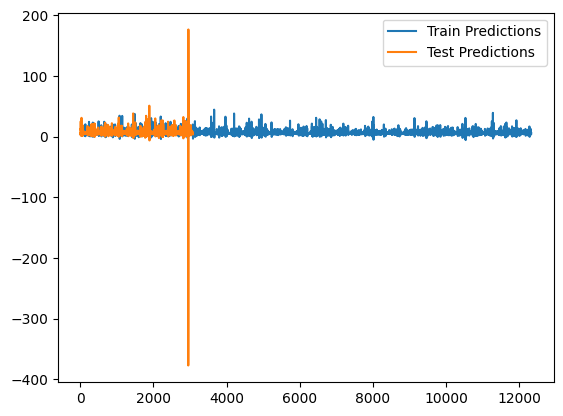

In [37]:
# Plot the predicted values and actual values
plt.plot(train_predictions[:, 0], label='Train Predictions')
plt.plot(test_predictions[:, 0], label='Test Predictions')
plt.legend()
plt.show()